## Setup

### Import Libraries, Set up device, Set up seeds

In [267]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import gpytorch
import math
import seaborn as sns
import random
from tqdm import trange
from collections import Counter
from scipy.interpolate import splrep, interp1d
from sklearn import preprocessing
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.likelihoods import GaussianLikelihood, StudentTLikelihood
from gpytorch.models import ApproximateGP
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.mlls import ExactMarginalLogLikelihood, VariationalELBO
import matplotlib.ticker as ticker
import matplotlib.tri as tri
import matplotlib.font_manager as font_manager


# check for MPS and CUDA device availability
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found, setting as device.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device found, setting as device.")
else:
    device = torch.device("cpu")
    print("Neither MPS nor CUDA device found. Using default device (CPU).")


# set the seed for all random use
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)

# Initial setup
training_iterations = 50
num_initial_points = 5
num_new_samples_per_iteration = 1  # Change this to your desired number of new samples per iteration

CUDA device found, setting as device.


### Student-T Process Model

In [268]:
class STP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=False
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Exact Gaussian Process Model

In [269]:
class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        # build the model using the ExactGP model from gpytorch
        super(ExactGP, self).__init__(x_train, y_train, likelihood)

        # use a constant mean, this value can be learned from the dataset
        self.mean_module = gpytorch.means.ConstantMean()

        # automatically determine the number of dimensions for the ARD kernel
        num_dimensions = x_train.shape[1]

        # use a scaled Matern kernel, the ScaleKernel allows the kernel to learn a scale factor for the dataset
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5,ard_num_dims=num_dimensions))
            
        # set the number of outputs 
        self.num_outputs = 1

    def forward(self, x):
        # forward pass of the model

        # compute the mean and covariance of the model 
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # return the MultivariateNormal distribution of the mean and covariance 
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    

### Variational Gaussian Process Model

In [270]:
class VariationalGP(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(VariationalGP, self).__init__(variational_strategy)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=inducing_points.size(1)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Standard Scalars

In [271]:
class TorchStandardScaler:
    def fit(self, x):
        x = x.clone()
        # calculate mean and std of the tensor
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
    def transform(self, x):
        x = x.clone()
        # standardize the tensor
        x -= self.mean
        x /= (self.std + 1e-10)
        return x
    def fit_transform(self, x):
        # copy the tensor as to not modify the original 
        x = x.clone()
        # calculate mean and std of the tensor
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
        # standardize the tensor
        x -= self.mean
        x /= (self.std + 1e-10)
        return x
    
class TorchNormalizer:
    def fit(self, x):
        # calculate the maximum value and the minimum value of the tensor
        self.max = torch.max(x, dim=0).values
        self.min = torch.min(x, dim=0).values

    def transform(self, x):
        # normalize the tensor
        return (x.clone() - self.min) / (self.max - self.min)

    def fit_transform(self, x):
        # calculate the maximum value and the minimum value of the tensor
        self.max = torch.max(x, dim=0).values
        self.min = torch.min(x, dim=0).values
        # normalize the tensor
        return (x.clone() - self.min) / (self.max - self.min)

### Acquisition Functions

In [272]:
# Upper Confidence Bound
def UCB(mean, std, beta):
    return mean + beta * std


# Expected Improvement
def EI(mean, std, best_observed):
    z = (mean - best_observed) / std
    return (mean - best_observed) * torch.distributions.Normal(0, 1).cdf(z) + std * torch.distributions.Normal(0, 1).log_prob(z)

### Randomly initialize training data with 10 points


In [273]:
dataset = 'Perovskite'
data = pd.read_csv(f"datasets/{dataset}_dataset.csv")

# merge rows that have the same output values
data = data.groupby(list(data.columns[:-1]), as_index=False).mean()
data = pd.DataFrame(data.reset_index())

# create tensors of the input and output data
train_x = torch.tensor(data.iloc[:, :-1].values)
train_y = torch.tensor(data.iloc[:, -1].values)

# We are using prededfined candidates, so we can scale at the start
TorchStd = TorchStandardScaler()
TorchStd.fit(train_x)

total_samples = len(train_y)


### Performance Comparisons Setup

In [274]:
import numpy as np
import torch

set_seeds(42)

N = len(data)
print(f"Number of samples: {N}")
n_top = int(math.ceil(N * 0.05))

# find the top 15% of the samples
top_samples = data.nsmallest(n_top, data.columns[-1], keep='first').iloc[:,-1:].values.tolist()
top_samples = [item for sublist in top_samples for item in sublist]
print(f"Number of of top 5% samples: {len(top_samples)}")

topEGP = [0]
topVGP = [0]

def TopSamplesAmnt(y, top_samples):
    return len([i for i in y if i in top_samples]) / len(top_samples)

campaigns = 10

# Generate a list of seeds randomly picked from the range 0-1000 equal to the number of campaigns without repeating
seedList = random.sample(range(1000), campaigns)

print(len(seedList))
for i in range(len(seedList)):
    print(f"Seed: {seedList[i]}")

Number of samples: 94
Number of of top 5% samples: 5
10
Seed: 654
Seed: 114
Seed: 25
Seed: 759
Seed: 281
Seed: 250
Seed: 228
Seed: 142
Seed: 754
Seed: 104


## Bayesian Optimization Loop

### Student-T Process Optimization

In [275]:

def modelRun(seed):
    
    set_seeds(seed)
    iterationSTP = [0]
    topSTP = [0]
    indicesSTP = torch.randperm(total_samples)[:num_initial_points]
    train_xSTP = train_x[indicesSTP]
    train_ySTP = train_y[indicesSTP]
    print(f"Seed: {seed}")
    print(f"Initial points: {train_xSTP}")
    globals()['initialPoints' + str(i)] = train_xSTP
    globals()['initialPointsy' + str(i)] = train_ySTP
    
    while topSTP[-1] < 100:
        iterationSTP.append(iterationSTP[-1] + 1)
        # standardize the initial inputs and outputs before
        torch_std = TorchStandardScaler()
        train_xSTP = torch_std.fit_transform(train_xSTP)
        y_scaler = TorchStandardScaler()
        train_ySTP = y_scaler.fit_transform(train_ySTP).flatten()  # Ensure y is 1-dimensional

        #def train_and_test_approximate_gp(objective_function_cls):
        model = STP(train_xSTP).to(dtype=torch.float64)
        #likelihood = gpytorch.likelihoods.GaussianLikelihood()
        likelihood = gpytorch.likelihoods.StudentTLikelihood()
        objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_ySTP.numel())
        # replace with gpytorch mll
        optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

        

        # Train
        model.train()
        #put it into training mode
        likelihood.train()

        for _ in range(50):
            output = model(train_xSTP)
            loss = -objective_function(output, train_ySTP)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            


        # Test
        model.eval()
        likelihood.eval()

        # works wtih the variational distribution
        with gpytorch.settings.num_likelihood_samples(512):
            observed_pred = likelihood(model(train_x))

        samples = observed_pred.sample()


        # use as inputs to UCB 
        meanSTP = samples.mean(dim=0)
        stdSTP = samples.std(dim=0)
        

        # Select new points using UCB
        ucb_values = UCB(meanSTP, stdSTP, 1.96)
        ucb_values[indicesSTP] = float('inf')
        indicesSTP = torch.cat([indicesSTP, ucb_values.argmin().unsqueeze(0)])


        # Convert new_indices to a tensor
        # Add the new points to the training data
        train_xSTP = train_x[indicesSTP]
        train_ySTP = train_y[indicesSTP]
        topSTP.append(TopSamplesAmnt(train_ySTP[num_initial_points:], top_samples)*100)
        if iterationSTP[-1] > 154:
            print("Maximum number of iterations exceeded, breaking loop.")
            return topSTP, iterationSTP
            break
        
    return topSTP, iterationSTP
        
for i in trange(len(seedList)):
    globals()['topSTP' + str(i)], globals()['iterationSTP' + str(i)] = modelRun(seedList[i])





Seed: 654
Initial points: tensor([[42.0000,  0.2600,  0.3700,  0.3600],
        [41.0000,  0.2500,  0.7500,  0.0000],
        [18.0000,  0.1600,  0.7000,  0.1400],
        [28.0000,  0.1900,  0.8100,  0.0000],
        [68.0000,  0.5000,  0.5000,  0.0000]], dtype=torch.float64)
Seed: 114
Initial points: tensor([[6.8000e+01, 5.0000e-01, 5.0000e-01, 0.0000e+00],
        [8.9000e+01, 8.8000e-01, 0.0000e+00, 1.2000e-01],
        [5.2000e+01, 3.1000e-01, 3.6000e-01, 3.3000e-01],
        [6.0000e+00, 6.0000e-02, 8.5000e-01, 9.0000e-02],
        [5.1000e+01, 3.1000e-01, 3.0000e-01, 3.9000e-01]], dtype=torch.float64)
Seed: 25
Initial points: tensor([[7.6000e+01, 7.0000e-01, 2.9000e-01, 1.0000e-02],
        [3.0000e+00, 0.0000e+00, 7.5000e-01, 2.5000e-01],
        [9.2000e+01, 9.6000e-01, 4.0000e-02, 0.0000e+00],
        [3.2000e+01, 2.2000e-01, 7.8000e-01, 0.0000e+00],
        [8.1000e+01, 7.6000e-01, 2.4000e-01, 0.0000e+00]], dtype=torch.float64)
Seed: 759
Initial points: tensor([[7.6000e+01, 

### Exact Gaussian Process Optimization

In [276]:
def runMinEGP(seed):
    set_seeds(seed)    
    iterationEGP = [0]
    topEGP = [0]
    indicesEGP = torch.randperm(total_samples)[:num_initial_points]
    train_xEGP = train_x[indicesEGP]
    train_yEGP = train_y[indicesEGP]
    print(f"Seed: {seed}")
    print(f"Initial points: {train_xEGP}")
    globals()['initialPoints' + str(i)] = train_xEGP
    globals()['initialPointsy' + str(i)] = train_yEGP
    iterationEGP = [0]
    while topEGP[-1] < 100:
        iterationEGP.append(iterationEGP[-1] + 1)
        # standardize the initial inputs and outputs before
        torch_std = TorchStandardScaler()
        train_xEGP = torch_std.fit_transform(train_xEGP)
        y_scaler = TorchStandardScaler()
        train_yEGP = y_scaler.fit_transform(train_yEGP).flatten()

        # optimize the model
        # use a half normal prior for the noise to find a Gaussian likelihood
        likelihood = GaussianLikelihood(noise_prior=gpytorch.priors.HalfNormalPrior(0.01))

        # using the found likelihood, create a GP model
        gp = ExactGP(train_xEGP, train_yEGP, likelihood)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

        # fit the model by maximizing the marginal log likelihood
        gp.train()
        likelihood.train()
        fit_gpytorch_mll(mll)

        gp.eval()
        likelihood.eval()

        # predict from candidate pool
        with torch.no_grad():
            pred = gp(train_x) # predict values for all candidates

        meanEGP = pred.mean
        stdEGP = pred.stddev

        # pass the predictions through an acquisition function to find the next best point to sample
        acqVal = UCB(meanEGP, stdEGP, 1.96)
        acqVal[indicesEGP] = float('inf')  # Don't select already sampled points
        indicesEGP = torch.cat([indicesEGP, acqVal.argmin().unsqueeze(0)]) # add best value to index

        # add the new point to the training data
        train_xEGP = train_x[indicesEGP]
        train_yEGP = train_y[indicesEGP]
        topEGP.append(TopSamplesAmnt(train_yEGP[num_initial_points:], top_samples)*100)
        
        if iterationEGP[-1] > len(train_x) - num_initial_points:
            print("Maximum number of iterations exceeded, breaking loop.")
            return topEGP, iterationEGP
            break

    return topEGP, iterationEGP

for i in trange(len(seedList)):
    globals()['topEGP' + str(i)], globals()['iterationEGP' + str(i)] = runMinEGP(seedList[i])

Seed: 654
Initial points: tensor([[42.0000,  0.2600,  0.3700,  0.3600],
        [41.0000,  0.2500,  0.7500,  0.0000],
        [18.0000,  0.1600,  0.7000,  0.1400],
        [28.0000,  0.1900,  0.8100,  0.0000],
        [68.0000,  0.5000,  0.5000,  0.0000]], dtype=torch.float64)
Seed: 114
Initial points: tensor([[6.8000e+01, 5.0000e-01, 5.0000e-01, 0.0000e+00],
        [8.9000e+01, 8.8000e-01, 0.0000e+00, 1.2000e-01],
        [5.2000e+01, 3.1000e-01, 3.6000e-01, 3.3000e-01],
        [6.0000e+00, 6.0000e-02, 8.5000e-01, 9.0000e-02],
        [5.1000e+01, 3.1000e-01, 3.0000e-01, 3.9000e-01]], dtype=torch.float64)
Seed: 25
Initial points: tensor([[7.6000e+01, 7.0000e-01, 2.9000e-01, 1.0000e-02],
        [3.0000e+00, 0.0000e+00, 7.5000e-01, 2.5000e-01],
        [9.2000e+01, 9.6000e-01, 4.0000e-02, 0.0000e+00],
        [3.2000e+01, 2.2000e-01, 7.8000e-01, 0.0000e+00],
        [8.1000e+01, 7.6000e-01, 2.4000e-01, 0.0000e+00]], dtype=torch.float64)
Seed: 759
Initial points: tensor([[7.6000e+01, 

### Variational Gaussian Process Optimization

In [277]:
def runMinVGP(seed):    
    set_seeds(seed)
    iterationVGP = [0]
    topVGP = [0]
    indicesVGP = torch.randperm(total_samples)[:num_initial_points]
    train_xVGP = train_x[indicesVGP]
    train_yVGP = train_y[indicesVGP]
    print(f"Seed: {seed}")
    print(f"Initial points: {train_xVGP}")
    globals()['initialPoints' + str(i)] = train_xVGP
    globals()['initialPointsy' + str(i)] = train_yVGP    
    iterationVGP = [0]
    while topVGP[-1] < 100:
        
        iterationVGP.append(iterationVGP[-1] + 1)
        # standardize the initial inputs and outputs before
        # torch_std = TorchStandardScaler()
        # train_xSTP = torch_std.fit_transform(train_xSTP)
        # y_scaler = TorchStandardScaler()
        # train_ySTP = y_scaler.fit_transform(train_ySTP).flatten()  # Ensure y is 1-dimensional

        #def train_and_test_approximate_gp(objective_function_cls):
        model = VariationalGP(train_xVGP).to(dtype=torch.float64)

        likelihood = GaussianLikelihood()
        objective_function = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_yVGP.numel())
        # replace with gpytorch mll
        optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

        # Train
        model.train()
        #put it into training mode
        likelihood.train()

        for _ in range(50):
            output = model(train_xVGP)
            loss = -objective_function(output, train_yVGP)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Test
        model.eval()
        likelihood.eval()

        # works wtih the variational distribution
        with gpytorch.settings.num_likelihood_samples(512):
            observed_pred = likelihood(model(train_x))

        samples = observed_pred.sample(torch.Size((100,)))

        # get the mean and standard deviation of the samples
        meanVGP = samples.mean(dim=0)
        stdVGP = samples.std(dim=0)

        # Select new points using UCB
        ucb_values = UCB(meanVGP, stdVGP, 1.96)
        ucb_values[indicesVGP] = float('inf')
        indicesVGP = torch.cat([indicesVGP, ucb_values.argmin().unsqueeze(0)])


        # Convert new_indices to a tensor
        # Add the new points to the training data
        train_xVGP = train_x[indicesVGP]
        train_yVGP = train_y[indicesVGP]
        topVGP.append(TopSamplesAmnt(train_yVGP[num_initial_points:], top_samples)*100)
        if iterationVGP[-1] > 154:
            print("Maximum number of iterations exceeded, breaking loop.")
            return topVGP, iterationVGP
            break

    return topVGP, iterationVGP

for i in trange(len(seedList)):
    globals()['topVGP' + str(i)], globals()['iterationVGP' + str(i)] = runVGP(seedList[i])

  0%|          | 0/10 [00:00<?, ?it/s]

Seed: 654
Initial points: tensor([[42.0000,  0.2600,  0.3700,  0.3600],
        [41.0000,  0.2500,  0.7500,  0.0000],
        [18.0000,  0.1600,  0.7000,  0.1400],
        [28.0000,  0.1900,  0.8100,  0.0000],
        [68.0000,  0.5000,  0.5000,  0.0000]], dtype=torch.float64)


 10%|█         | 1/10 [00:15<02:15, 15.02s/it]

Seed: 114
Initial points: tensor([[6.8000e+01, 5.0000e-01, 5.0000e-01, 0.0000e+00],
        [8.9000e+01, 8.8000e-01, 0.0000e+00, 1.2000e-01],
        [5.2000e+01, 3.1000e-01, 3.6000e-01, 3.3000e-01],
        [6.0000e+00, 6.0000e-02, 8.5000e-01, 9.0000e-02],
        [5.1000e+01, 3.1000e-01, 3.0000e-01, 3.9000e-01]], dtype=torch.float64)


 20%|██        | 2/10 [00:26<01:43, 12.97s/it]

Seed: 25
Initial points: tensor([[7.6000e+01, 7.0000e-01, 2.9000e-01, 1.0000e-02],
        [3.0000e+00, 0.0000e+00, 7.5000e-01, 2.5000e-01],
        [9.2000e+01, 9.6000e-01, 4.0000e-02, 0.0000e+00],
        [3.2000e+01, 2.2000e-01, 7.8000e-01, 0.0000e+00],
        [8.1000e+01, 7.6000e-01, 2.4000e-01, 0.0000e+00]], dtype=torch.float64)


 30%|███       | 3/10 [00:37<01:24, 12.08s/it]

Seed: 759
Initial points: tensor([[7.6000e+01, 7.0000e-01, 2.9000e-01, 1.0000e-02],
        [3.1000e+01, 2.2000e-01, 7.2000e-01, 6.0000e-02],
        [7.9000e+01, 7.5000e-01, 0.0000e+00, 2.5000e-01],
        [7.8000e+01, 7.1000e-01, 6.0000e-02, 2.3000e-01],
        [1.2000e+01, 1.2000e-01, 7.7000e-01, 1.1000e-01]], dtype=torch.float64)


 40%|████      | 4/10 [00:51<01:17, 12.98s/it]

Seed: 281
Initial points: tensor([[1.0000e+01, 1.0000e-01, 8.9000e-01, 1.0000e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [7.4000e+01, 6.8000e-01, 1.3000e-01, 1.9000e-01],
        [3.6000e+01, 2.5000e-01, 0.0000e+00, 7.5000e-01],
        [7.8000e+01, 7.1000e-01, 6.0000e-02, 2.3000e-01]], dtype=torch.float64)


 50%|█████     | 5/10 [01:05<01:06, 13.35s/it]

Seed: 250
Initial points: tensor([[3.2000e+01, 2.2000e-01, 7.8000e-01, 0.0000e+00],
        [6.1000e+01, 3.8000e-01, 6.2000e-01, 0.0000e+00],
        [4.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
        [2.3000e+01, 1.7000e-01, 8.2000e-01, 1.0000e-02],
        [7.9000e+01, 7.5000e-01, 0.0000e+00, 2.5000e-01]], dtype=torch.float64)


 60%|██████    | 6/10 [01:19<00:54, 13.53s/it]

Seed: 228
Initial points: tensor([[6.7000e+01, 5.0000e-01, 2.5000e-01, 2.5000e-01],
        [6.8000e+01, 5.0000e-01, 5.0000e-01, 0.0000e+00],
        [7.7000e+01, 7.1000e-01, 1.0000e-02, 2.8000e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [4.2000e+01, 2.6000e-01, 3.7000e-01, 3.6000e-01]], dtype=torch.float64)


 70%|███████   | 7/10 [01:37<00:44, 14.83s/it]

Seed: 142
Initial points: tensor([[7.7000e+01, 7.1000e-01, 1.0000e-02, 2.8000e-01],
        [5.3000e+01, 3.2000e-01, 6.7000e-01, 1.0000e-02],
        [4.9000e+01, 3.0000e-01, 3.9000e-01, 3.2000e-01],
        [8.1000e+01, 7.6000e-01, 2.4000e-01, 0.0000e+00],
        [3.8000e+01, 2.5000e-01, 5.0000e-01, 2.5000e-01]], dtype=torch.float64)


 80%|████████  | 8/10 [01:53<00:30, 15.39s/it]

Seed: 754
Initial points: tensor([[6.7000e+01, 5.0000e-01, 2.5000e-01, 2.5000e-01],
        [1.7000e+01, 1.4000e-01, 8.4000e-01, 2.0000e-02],
        [1.9000e+01, 1.6000e-01, 7.5000e-01, 9.0000e-02],
        [4.3000e+01, 2.6000e-01, 3.8000e-01, 3.6000e-01],
        [8.0000e+00, 9.0000e-02, 8.7000e-01, 4.0000e-02]], dtype=torch.float64)


 90%|█████████ | 9/10 [02:09<00:15, 15.60s/it]

Seed: 104
Initial points: tensor([[1.7000e+01, 1.4000e-01, 8.4000e-01, 2.0000e-02],
        [3.6000e+01, 2.5000e-01, 0.0000e+00, 7.5000e-01],
        [3.0000e+00, 0.0000e+00, 7.5000e-01, 2.5000e-01],
        [5.3000e+01, 3.2000e-01, 6.7000e-01, 1.0000e-02],
        [2.6000e+01, 1.8000e-01, 8.2000e-01, 0.0000e+00]], dtype=torch.float64)


100%|██████████| 10/10 [02:48<00:00, 16.90s/it]

Maximum number of iterations exceeded, breaking loop.


## Visualization

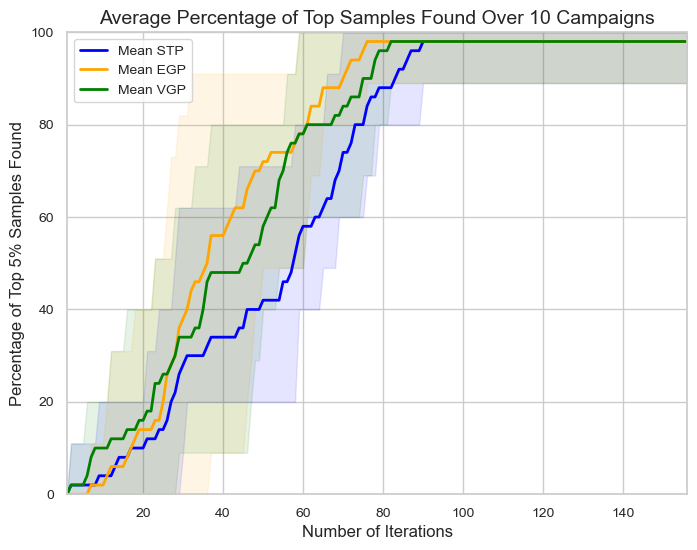

In [282]:
num_arrays = len(seedList)  
# Function to dynamically collect arrays
def collect_arrays(prefix, num_arrays):
    arrays = []
    for i in range(num_arrays):
        array = globals().get(f'{prefix}{i}', None)
        if array is not None:
            arrays.append(array)
    return arrays

# Function to pad arrays with the last element to match the maximum length
def pad_array(array, max_length):
    return np.pad(array, (0, max_length - len(array)), 'constant', constant_values=array[-1])

def find_max_length(prefix, num_arrays):
    arrays = collect_arrays(prefix, num_arrays)
    return max(len(arr) for arr in arrays)

# Process arrays for each type
def process_arrays(prefix, num_arrays, max_length):
    arrays = collect_arrays(prefix, num_arrays)
    padded_arrays = [pad_array(arr, max_length) for arr in arrays]
    stack = np.stack(padded_arrays)
    mean_values = np.mean(stack, axis=0)
    p5_values = np.percentile(stack, 5, axis=0)
    p95_values = np.percentile(stack, 95, axis=0)
    return mean_values, p5_values, p95_values

# Process arrays for STP, EGP, and VGP
max_length_STP = find_max_length('topSTP', num_arrays)
max_length_EGP = find_max_length('topEGP', num_arrays)
max_length_VGP = find_max_length('topVGP', num_arrays)
max_length = max(max_length_STP, max_length_EGP, max_length_VGP)
mean_topSTP, p5_topSTP, p95_topSTP = process_arrays('topSTP', num_arrays, max_length)
mean_topEGP, p5_topEGP, p95_topEGP = process_arrays('topEGP', num_arrays, max_length)
mean_topVGP, p5_topVGP, p95_topVGP = process_arrays('topVGP', num_arrays, max_length)

# Ensure that the number of iterations matches the longest array length
max_length = max(max_length_STP, max_length_EGP)
iterations = np.arange(1, max_length + 1)


sns.set(style="whitegrid")
# Plot the mean and fill between the min and max for each type
plt.figure(figsize=(8, 6))

# Plot for STP
sns.lineplot(x=iterations, y=mean_topSTP, label='Mean STP', color='blue', linewidth=2)
plt.fill_between(iterations, p5_topSTP, p95_topSTP, color='blue', alpha=0.1)

# Plot for EGP
sns.lineplot(x=iterations, y=mean_topEGP, label='Mean EGP', color='orange', linewidth=2)
plt.fill_between(iterations, p5_topEGP, p95_topEGP, color='orange', alpha=0.1)

# Plot for VGP
plt.plot(iterations, mean_topVGP, label='Mean VGP', color='green', linewidth=2)
plt.fill_between(iterations, p5_topVGP, p95_topVGP, color='green', alpha=0.1)

plt.xlabel('Number of Iterations', fontsize=12)
plt.ylabel('Percentage of Top 5% Samples Found', fontsize=12)
plt.title(f'Average Percentage of Top Samples Found Over {num_arrays} Campaigns', fontsize=14)
plt.legend(fontsize=10, loc='upper left')

# Customize ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adjust axis limits and aspect ratio if needed
plt.ylim(0, 100)
plt.xlim(1, max_length)


# save the plot 
plt.savefig(f"{dataset}_1top_samples")
plt.show()